In [20]:
import kagglehub
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

#FDataset fuente
data = kagglehub.dataset_download("jahnavipaliwal/customer-feedback-and-satisfaction")
file_path = os.path.join(data, "customer_feedback_satisfaction.csv")

#Convertir a DataFrame
df = pd.read_csv(file_path)
df2 = df.copy()

#Ver detalle de la data
print(df.describe())

#Revisar si hay datos null
print(df.isnull().sum())

#Revisar si hay datos duplicados
print("\nCantidad de datos duplicados: ", df.duplicated().sum())

#Eliminar columnas innecesarias
df.drop(columns=['CustomerID'], inplace = True)

#Convertir genero a variables numericas
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

#Convertir Feedback a variables numericas
df['FeedbackScore'] = df['FeedbackScore'].map({'Low': 0, 'Medium': 1, 'High' : 2})

#Convertir Feedback a variables numericas
df['LoyaltyLevel'] = df['LoyaltyLevel'].map({'Bronze': 0, 'Silver': 1, 'Gold' : 2})

#Convertir pais a variable numerica
df['CountryS'] = df['Country'].map({'UK': 0, 'USA': 1, 'France' : 2, 'Germany' : 3, 'Canada': 4})

#Escalar sueldo debido a la magnitud de los numeros
scaler = MinMaxScaler()
df['IncomeS'] = scaler.fit_transform(df[['Income']])

#Escalar edad debido a la magnitud de los numeros
scaler = MinMaxScaler()
df['AgeS'] = scaler.fit_transform(df[['Age']])


         CustomerID           Age         Income  ProductQuality  \
count  38444.000000  38444.000000   38444.000000    38444.000000   
mean   19222.500000     43.496853   75076.619238        5.494746   
std    11097.971211     14.972748   25975.752966        2.873192   
min        1.000000     18.000000   30001.000000        1.000000   
25%     9611.750000     31.000000   52624.500000        3.000000   
50%    19222.500000     43.000000   75236.000000        5.000000   
75%    28833.250000     56.000000   97606.750000        8.000000   
max    38444.000000     69.000000  119999.000000       10.000000   

       ServiceQuality  PurchaseFrequency  SatisfactionScore  
count    38444.000000       38444.000000       38444.000000  
mean         5.492769          10.453881          85.276409  
std          2.875812           5.765621          16.898577  
min          1.000000           1.000000           4.280000  
25%          3.000000           5.000000          74.470000  
50%          5.

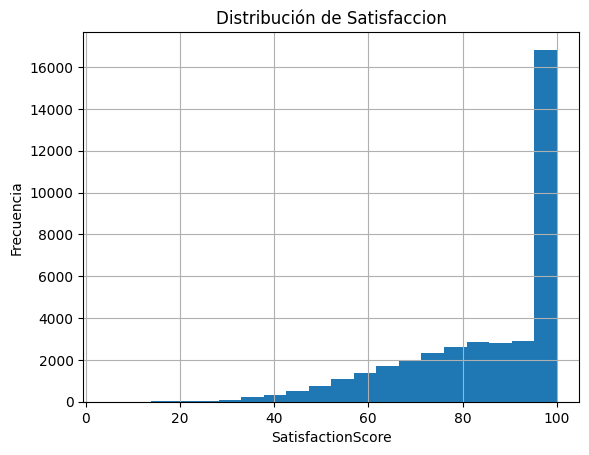

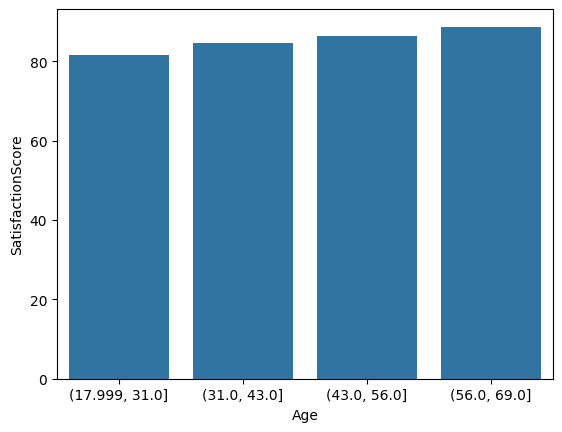

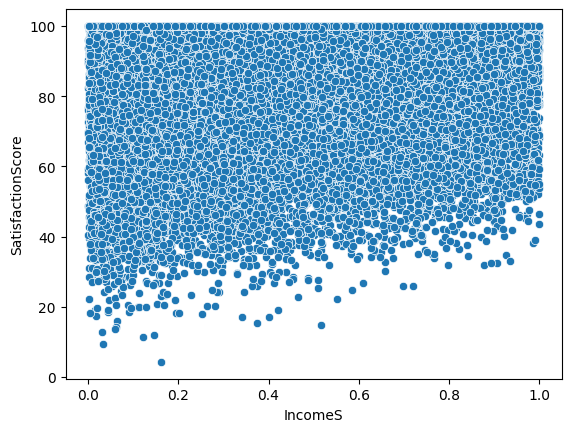

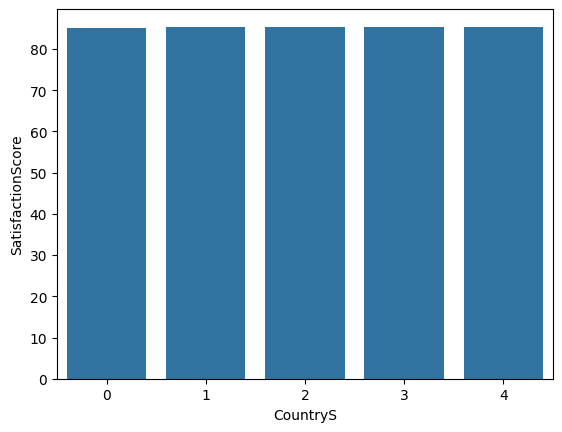

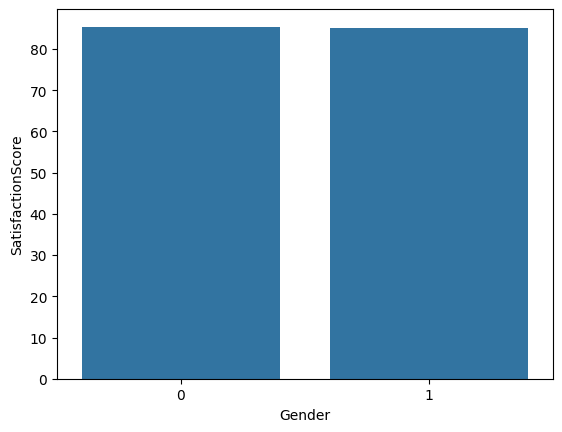

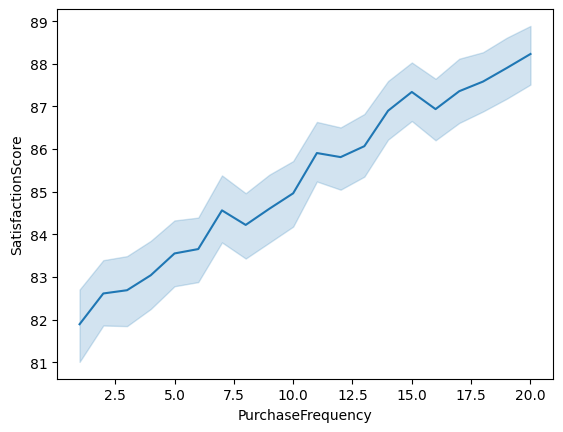

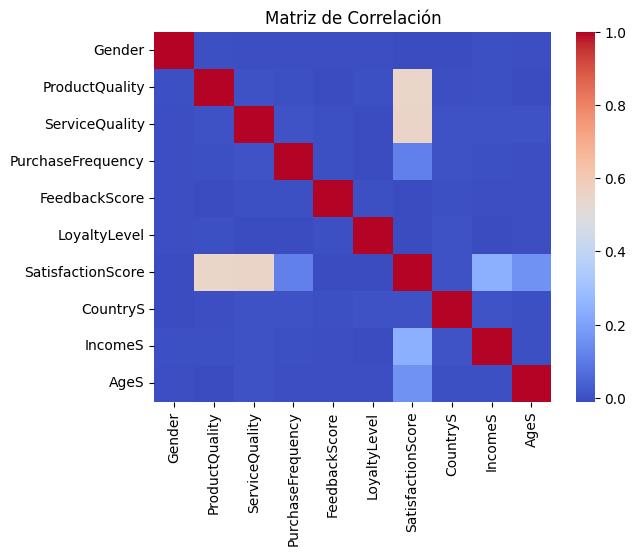

In [3]:
#### ANALISIS ####

#Distribucion de los valores de satisfaccion
df['SatisfactionScore'].hist(bins=20)
plt.title('Distribución de Satisfaccion')
plt.xlabel('SatisfactionScore')
plt.ylabel('Frecuencia')
plt.show()

#Satisfaccion por edad
df['Age'] = pd.qcut(df.Age,4)
sns.barplot(x='Age',y='SatisfactionScore', errorbar=None, data=df)
plt.show()

#Relacion salario vs satisfaccion
sns.scatterplot(data=df, x='IncomeS', y='SatisfactionScore')
plt.show()

#Satisfaccion por Genero
sns.barplot(x='CountryS', y='SatisfactionScore', errorbar=None, data=df)
plt.show()

#Satisfaccion por Pais
sns.barplot(x='Gender', y='SatisfactionScore', errorbar=None, data=df)
plt.show()

#Relacion de frecuencia de compra vs satisfaccion
sns.lineplot(data=df, x='PurchaseFrequency', y='SatisfactionScore')
plt.show()

#Eliminar columnas
#Ya fueron vectorizadas
df.drop(columns=['Age'], inplace=True)
df.drop(columns=['Income'], inplace=True)
df.drop(columns=['Country'], inplace=True)

#Matriz de correlacion
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

plt.title('Matriz de Correlación')
plt.show()

In [ ]:
#### ENTRENAMIENTO DEL MODELO ####
#Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

#Separar X, Y (Datos de entrada, Datos de salida)
X = df.drop(columns=['SatisfactionScore'])
Y = df.SatisfactionScore

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

train = model.predict(X_test)
error = mean_squared_error(y_test, train)
print(f'Error Cuadrático Medio: {error}')

#Ejercicio extra: Chatbot entrenado

Error Cuadrático Medio: 65.34194375727662


In [ ]:
#### PRUEBA DE PARAMETROS ####
#GridSearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test)
best_error = mean_squared_error(y_test, best_predictions)
print(f'Best Error Cuadrático Medio: {best_error}')

Best Error Cuadrático Medio: 62.15781703374362


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

df2.drop(columns=['CustomerID'])
Y = df2['SatisfactionScore']
df2.drop(columns=['SatisfactionScore'])

#Escalar la data
escalado = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age','Income','ProductQuality','ServiceQuality','PurchaseFrequency']),
        ('cat', OneHotEncoder(), ['Gender', 'Country','FeedbackScore','LoyaltyLevel'])
    ])

X = escalado.fit_transform(df2)


[ 0.83507114  0.30865265 -0.17219594  0.87184548 -0.94594346  0.
  1.          0.          0.          0.          1.          0.
  0.          1.          0.          1.          0.          0.        ]


In [34]:
#### ENTRENAMIENTO DEL MODELO ####
#Red Neuronal
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split


#Separar X, Y (Datos de entrada, Datos de salida)
#X = df.drop(columns=['SatisfactionScore'])
#Y = df.SatisfactionScore

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Se crea una red neuronal, primero los 9 parametros, capa oculta de 64, capa oculta de 32 y la neurona de salida
model = Sequential()
model.add(Input(shape=(18,)))
model.add(Dense(64, activation='softmax'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compilar el modelo con el error medio cuadratico
model.compile(optimizer='adam',
              loss='mean_squared_error')

#Ajustar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

#Margen de error
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

Epoch 1/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6376.1196 - val_loss: 752.9497
Epoch 2/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 387.9516 - val_loss: 85.6653
Epoch 3/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 76.9717 - val_loss: 68.3547
Epoch 4/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 66.0263 - val_loss: 65.0046
Epoch 5/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 64.6925 - val_loss: 62.9118
Epoch 6/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 63.4896 - val_loss: 61.3710
Epoch 7/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 61.5037 - val_loss: 60.5767
Epoch 8/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 61.1706 - val_loss: 59.8756
Epoch 9/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 59.8175 - val_loss: 59.5568
Epoch 10/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 60.8429 - val_loss: 59.5539
Epoch 11/50
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 60.3995 - val_loss: 59.2075
Epoch 12/50
769/769 ━━━━━━